In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.functional as F
from matplotlib import pyplot as plt
import pickle 

### BC Policy with MSE loss

#### Prepare data

In [2]:
data_path="expert_data/Pendulum-v1_10_-130.pkl"

In [3]:
with open(data_path, "rb") as f:
    data_good = pickle.load(f)
print('expert data loaded')

data_good=data_good[:20]

good_obs=[]
good_acts=[] 
for traj in data_good: 
    s,a,r=traj   
    good_obs.append(s)
    good_acts.append(a) 

states=np.vstack(good_obs)
actions=np.vstack(good_acts)
print('X:',states.shape,' y:', actions.shape)

expert data loaded
X: (2000, 3)  y: (2000, 1)


In [4]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 3]), torch.Size([64, 1]))

In [5]:
action_dim=actions.shape[1]
state_dim=states.shape[1]
print(state_dim, action_dim)

3 1


#### Train Model

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, size=32):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,32),
            nn.ReLU(), 
            nn.Linear(32,64),
            nn.ReLU(), 
            nn.Linear(64,32),
            nn.ReLU(),  
            nn.Linear(32,size),
        )
    def forward(self,x):
        x = self.net(x)
        return x
    
class RegNet(MLP):
    def __init__(self, input_dim , size, action_dim):
        super(RegNet, self).__init__(input_dim, size)
        self.decoder = nn.Linear(size, action_dim)
    def forward(self,x):
        x = self.net(x)
        x = self.decoder(x)
        return x

In [7]:
bc_pendulum = RegNet(state_dim, 32, action_dim)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(bc_pendulum.parameters(), lr = learning_rate)

In [8]:
loss_list = []
test_loss = []
batch_size = 256
n_epoch = 250
 
for itr in range(0, n_epoch+1):
    total_loss = 0
    b=0
    for batch_states, batch_actions in data_loader: 
        y_pred = bc_pendulum(batch_states)
        loss   = criterion(y_pred, batch_actions) 
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1 
        
        loss_list.append(loss.item())
        
    if itr % (n_epoch//20)==0:
        print(f'Epoch {itr} Loss: {total_loss/b:.3f}')

Epoch 0 Loss: 0.351
Epoch 12 Loss: 0.094
Epoch 24 Loss: 0.087
Epoch 36 Loss: 0.080
Epoch 48 Loss: 0.066
Epoch 60 Loss: 0.077
Epoch 72 Loss: 0.063
Epoch 84 Loss: 0.055
Epoch 96 Loss: 0.046
Epoch 108 Loss: 0.046
Epoch 120 Loss: 0.039
Epoch 132 Loss: 0.040
Epoch 144 Loss: 0.060
Epoch 156 Loss: 0.044
Epoch 168 Loss: 0.052
Epoch 180 Loss: 0.048
Epoch 192 Loss: 0.032
Epoch 204 Loss: 0.045
Epoch 216 Loss: 0.038
Epoch 228 Loss: 0.032
Epoch 240 Loss: 0.017


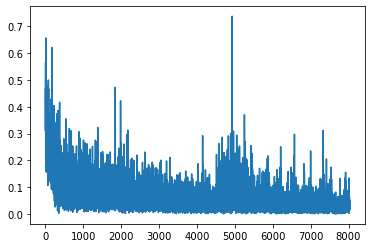

In [9]:
plt.plot(loss_list)

In [10]:
train_x=torch.tensor(states, dtype=torch.float)
train_y=torch.tensor(actions, dtype=torch.float)

In [11]:
yhat=bc_pendulum(train_x).detach().numpy()
score = 1 - ( (actions - yhat )**2 ).sum() /( (actions - actions.mean() )**2 ).sum()
print('regression score: ', score)

regression score:  tensor(0.8870)


#### Inference

In [12]:
def predict_action(state, model):
    state=torch.tensor(state, dtype=torch.float)
    action=model(state).detach().numpy()[0]
    return action

In [13]:
def play_an_episode(env_name, model, render=False, max_step=500):
    if render:
        env=gym.make(env_name, render_mode='human')
    else:
        env = gym.make(env_name)
    total_reward=0  
    state,info=env.reset() 
    for i in range(max_step):
        if render: env.render()
        action = predict_action(state, model)
        next_state,reward,done,trunc,info=env.step([action])
        total_reward+=reward
        state=next_state
        if done or trunc: break
#         else: print('i=',i)
    
    env.close()
    return total_reward

In [14]:
env_name='Pendulum-v1'

### Single rollout with visualization

In [15]:
rewards=play_an_episode(env_name, bc_pendulum, render=True) 
print('rewards:', rewards )

rewards: -1.2703630732549107


### mean reward over rollouts

In [16]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    rewards=play_an_episode(env_name, bc_pendulum)
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: -119.52
episode #1 reward: -1.66


episode #2 reward: -122.37
episode #3 reward: -252.34
episode #4 reward: -388.43
episode #5 reward: -124.31
episode #6 reward: -116.95
episode #7 reward: -244.63
episode #8 reward: -238.22
episode #9 reward: -229.17
episode #10 reward: -114.95
episode #11 reward: -121.05
episode #12 reward: -1.40
episode #13 reward: -233.72
episode #14 reward: -119.45
episode #15 reward: -115.55
episode #16 reward: -394.38
episode #17 reward: -118.66
episode #18 reward: -122.38
episode #19 reward: -125.79

 score: -165.25 +- 101.60
